In [1]:
import os
import numpy as np
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt
from train.dataloader import load_transformed_video
import cv2
import time
from utils import Calibration, draw_path, FULL_FRAME_SIZE, create_image_canvas, extract_preds
from matplotlib.patches import Patch

In [2]:
plot_img_height, plot_img_width = 480, 640 # can be reduced for wandb

In [3]:
real_preds = np.load('/home/nikita/data/2021-09-14--09-19-21/25/xyz_preds.npz')
real_paths_xyz = np.stack((real_preds['x'], real_preds['y'], real_preds['z']), axis=-1)
real_paths_xyz.shape

(1200, 33, 3)

#### Extract `seq_len`-th input_frame and bgr_frame from video:

In [4]:
path_to_segment = '/home/nikita/data/2021-09-14--09-19-21/25'
path_to_onnx_model = 'common/models/supercombo.onnx'
os.makedirs('outs', exist_ok=True)

input_frames, rgb_frames = load_transformed_video(path_to_segment, seq_len=50)


input_frame = input_frames[20]
rgb_frame = rgb_frames[20]

print('input frame:', input_frame.shape)
print('rgb frame:', input_frame.shape)

input frame: (12, 128, 256)
rgb frame: (12, 128, 256)


/home/nikita/openpilot-pipeline/utils.py:275: RuntimeWarning: divide by zero encountered in true_divide
  return (kep[:-1, :] / kep[-1, :]).T


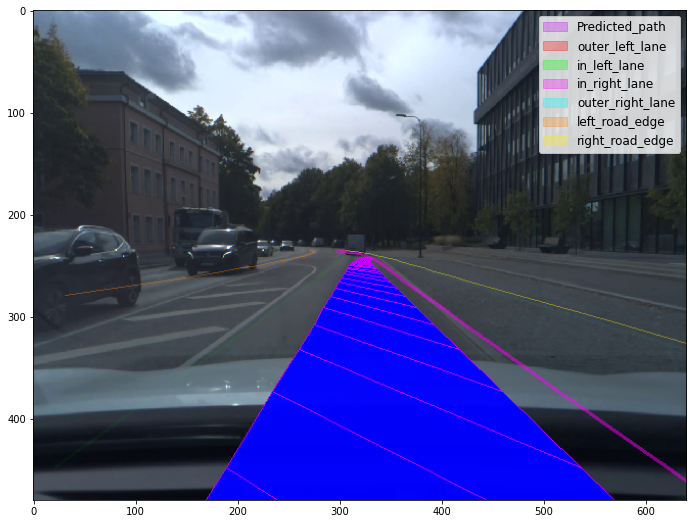

In [5]:
fill_color_gt = [0,  255, 0]
line_color_gt = [255,255, 0]
fill_color_preds = [0,  0,255]
line_color_preds = [200,0,255]
laneline_colors = [(255,0,0),(0,255,0),(255,0,255),(0,255,255)]
legend_laneline_colors = [[255,0,0],[0,255,0],[255,0,255],[0,255,255]]
legend_roadedge_colors = [[255,128,0],[255,234,0]]
X_IDXS = [
         0.    ,   0.1875,   0.75  ,   1.6875,   3.    ,   4.6875,
         6.75  ,   9.1875,  12.    ,  15.1875,  18.75  ,  22.6875,
        27.    ,  31.6875,  36.75  ,  42.1875,  48.    ,  54.1875,
        60.75  ,  67.6875,  75.    ,  82.6875,  90.75  ,  99.1875,
       108.    , 117.1875, 126.75  , 136.6875, 147.    , 157.6875,
       168.75  , 180.1875, 192.]

def legend_color(color, opacity=0.3):
    return np.append(np.array(color)/255, opacity)

model = onnx.load(path_to_onnx_model)

input_names = [node.name for node in model.graph.input]
output_names = [node.name for node in model.graph.output]

providers = ['CPUExecutionProvider']
onnxruntime_model = rt.InferenceSession(path_to_onnx_model, providers=providers)

recurrent_state = np.zeros((1, 512), dtype=np.float32)

inputs = {
    'input_imgs': np.expand_dims(input_frame.astype(np.float32), 0),
    'desire': np.zeros((1, 8), dtype=np.float32),
    'traffic_convention': np.array([0, 1], dtype=np.float32).reshape(1, 2),
    'initial_state': recurrent_state,
}

outs = onnxruntime_model.run(output_names, inputs)[0]
lanelines, road_edges, best_path = extract_preds(outs)[0] # extract sample id = 0

# print(lanelines[0].shape)
# plot predictions

rpy_calib_gt = [0.00018335809, 0.034165092, -0.014245722]  # real calibration values during this ride
rpy_calib_pred = [0, 0, 0]  # calibration we currently use for pre-processing

calibration_gt = Calibration(rpy_calib_gt, plot_img_width=plot_img_width, plot_img_height=plot_img_height)
calibration_pred = Calibration(rpy_calib_pred, plot_img_width=plot_img_width, plot_img_height=plot_img_height)

# path_xyz_gt = real_paths_xyz[t_idx]
path_xyz_pred = best_path[0, :, :3]

# img_plot = draw_path(path_xyz_gt, img_plot, calibration_gt, fill_color=fill_color_gt, line_color=line_color_gt)
img_plot = draw_path(lanelines, road_edges, path_xyz_pred, rgb_frame, calibration_pred, X_IDXS, laneline_colors, fill_color=fill_color_preds, line_color=line_color_preds)

plot_width = 12
plot_height = plot_width * (FULL_FRAME_SIZE[1] / FULL_FRAME_SIZE[0])
plt.figure(figsize=(plot_width, plot_height))

plt.imshow(img_plot)

legend_elements = [#Patch(facecolor=legend_color(fill_color_gt), edgecolor=legend_color(line_color_gt),label='Ground Truth'),
                   Patch(facecolor=legend_color(line_color_preds), edgecolor=legend_color(line_color_preds),
                         label='Predicted_path'),
                         Patch(facecolor=legend_color(laneline_colors[0]), edgecolor=legend_color(laneline_colors[0]),
                         label='outer_left_lane'),
                         Patch(facecolor=legend_color(laneline_colors[1]), edgecolor=legend_color(laneline_colors[1]),
                         label='in_left_lane'),
                         Patch(facecolor=legend_color(laneline_colors[2]), edgecolor=legend_color(laneline_colors[2]),
                         label='in_right_lane'),
                         Patch(facecolor=legend_color(laneline_colors[3]), edgecolor=legend_color(laneline_colors[3]),
                         label='outer_right_lane'),
                         Patch(facecolor=legend_color(legend_roadedge_colors[0]), edgecolor=legend_color(legend_roadedge_colors[0]),
                         label='left_road_edge'),
                         Patch(facecolor=legend_color(legend_roadedge_colors[1]), edgecolor=legend_color(legend_roadedge_colors[1]),
                         label='right_road_edge')
                         
                         ]

plt.legend(handles=legend_elements, loc='upper right', prop={'size': 12})
plt.show()

In [6]:
best_path.shape

(2, 33, 15)